
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW runup estimation 

inputs required: 
  * Nearshore reconstructed historical storms
  * Nearshore reconstructed simulated storms
  * Historical water levels
  * Synthetic water levels 

in this notebook:
  * HyCReWW runup estimation of historical and synthetic events
  * Extreme value analysis and validation


### Workflow:

<div>
<img src="resources/nb02_04.png" width="400px">
</div>



**HyCReWW** provides wave-driven run-up estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of run-up for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_reef$, $\beta_b$, $c_f$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), and seabed roughness ($c_f$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period. Beach crest elevation ($z_b$) was fixed at a height of 30 m to focus on run-up as a proxy for coastal inundation.

<img src="resources/nb02_04_profile.png">


In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/anacrueda/Documents/Proyectos/TESLA/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}


# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW()


In [3]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    print(len(dset))

    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]
        
    #d_out = dset.copy()
    #print(d_out)
    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] > var_lims[vn][0]) &(dset[vn] < var_lims[vn][1])]
        #d_out = d_out[(dset[vn] < var_lims[vn][0]) &(dset[vn] > var_lims[vn][1])]
    
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    
    print(len(dset))
    print(len(ds_in))
    #print(d_out)

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out



## Hycreww RBF Interpolation: Historical

In [93]:
# Load complete historical data and nearshore waves
data = db.Load_HIST_Complete_daily() 
waves = db.Load_NEARSHORE_RECONSTRUCTION_HIST_storms()

waves = waves.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
waves['hs_lo2'] = waves['hs']/(1.5613*waves['tp']**2)             # calc. hs_lo2
waves['level'] = data.sel(time=waves.time).level                  # add level


# calculate runup with hycreww
dset = waves[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist = hycreww_runup(var_lims, rbf_coeffs, dset)
print(dset)
# store historical runup
#db.Save_NEARSHORE_RUNUP_HIST(out_hist)


4163
1872
1872
                  hs         tp        dir  level    hs_lo2  rslope  bslope  \
time                                                                          
1979-02-14  1.455193   7.801798  20.754320    NaN  0.015312  0.0505  0.1667   
1979-02-17  1.350300  10.981978   3.171029    NaN  0.007171  0.0505  0.1667   
1979-02-19  1.400128   9.338189  16.025290    NaN  0.010284  0.0505  0.1667   
1979-02-22  1.419922  10.184916   3.145112    NaN  0.008767  0.0505  0.1667   
1979-02-26  1.446609   7.566327  28.476938    NaN  0.016184  0.0505  0.1667   
...              ...        ...        ...    ...       ...     ...     ...   
2016-12-25  1.335010  10.112284  21.921824    NaN  0.008362  0.0505  0.1667   
2016-12-26  1.585926   9.785069  47.127159    NaN  0.010609  0.0505  0.1667   
2016-12-27  1.475289   8.552520  30.575266    NaN  0.012918  0.0505  0.1667   
2016-12-29  1.458611   8.347192  14.858302    NaN  0.013408  0.0505  0.1667   
2016-12-31  1.444937   8.002734  31.3


## Hycreww RBF Interpolation: Simulation

In [5]:
# Load complete simulations data and nearshore waves

n_sims_DWT = 10
data_list = db.Load_SIM_Complete_storms(n_sims=n_sims_DWT)
waves_list = db.Load_NEARSHORE_RECONSTRUCTION_SIM_storms(n_sims=n_sims_DWT)

# iterate storms waves simulations
l_sims = []
for dd, ww in zip(data_list, waves_list):
    
    ww = ww.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
    ww['hs_lo2'] = ww['hs']/(1.5613*ww['tp']**2)                # calc. hs_lo2
    ww['level'] = dd.sel(time=ww.time).level                    # add level
    
    # calculate runup with hycreww
    dset = ww[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
    out_sim = hycreww_runup(var_lims, rbf_coeffs, dset)
    
    l_sims.append(out_sim)

    
# store simulation runup
db.Save_NEARSHORE_RUNUP_SIM(l_sims)


In [4]:
data = db.Load_HIST_Complete_daily() 
waves = db.Load_NEARSHORE_RECONSTRUCTION_HIST_storms()
hist_A = db.Load_NEARSHORE_RUNUP_HIST()

waves = waves.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
waves['hs_lo2'] = waves['hs']/(1.5613*waves['tp']**2)             # calc. hs_lo2
waves['level'] = data.sel(time=waves.time).level                  # add level

n_sims_DWT = 10

data_list = db.Load_SIM_Complete_storms(n_sims=n_sims_DWT)
waves_list = db.Load_NEARSHORE_RECONSTRUCTION_SIM_storms(n_sims=n_sims_DWT)
sim_A = db.Load_NEARSHORE_RUNUP_SIM(n_sims=n_sims_DWT)

In [9]:
print(data_list)

[<xarray.Dataset>
Dimensions:      (time: 113899)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 2999-12-31 00:00:00
Data variables:
    DWT          (time) float32 ...
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float32 ...
    swell_1_Tp   (time) float32 ...
    swell_1_Dir  (time) float32 ...
    swell_2_Hs   (time) float32 ...
    swell_2_Tp   (time) float32 ...
    swell_2_Dir  (time) float32 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    SS           (time) float32 ...
    AWL          (time) float32 ...
    AWT          (time) float32 ...
    MJO          (time) float32 ...
    MMSL         (time) float32 ...
    AT           (time) float32 ...
    TWL          (time) float32 ...
    level        (time) float32 ...
Attributes:
    source:   teslakit_v0.9.1, <xarray.Dataset>
Dimensions:      (time: 113749

In [14]:
print(data)

<xarray.Dataset>
Dimensions:      (time: 50350)
Coordinates:
  * time         (time) datetime64[ns] 1880-06-01 1880-06-02 ... 2018-04-08
Data variables:
    observed     (time) float32 ...
    ntr          (time) float32 ...
    sigma        (time) float32 ...
    AT           (time) float32 ...
    AWT          (time) float32 ...
    DWT          (time) float32 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float32 ...
    swell_1_Tp   (time) float32 ...
    swell_1_Dir  (time) float32 ...
    swell_2_Hs   (time) float32 ...
    swell_2_Tp   (time) float32 ...
    swell_2_Dir  (time) float32 ...
    TC_category  (time) float32 ...
    MJO          (time) float32 ...
    MMSL         (time) float32 ...
    AWL          (time) float32 ...
    TWL          (time) float32 ...
    level        (t

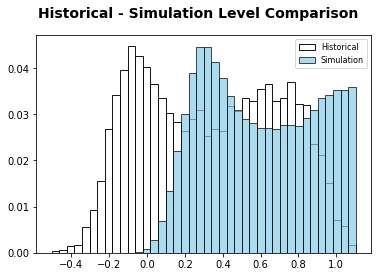

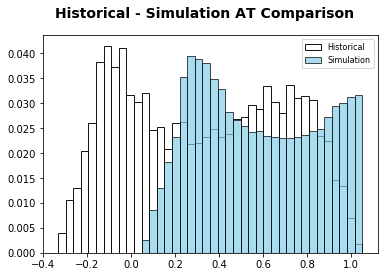

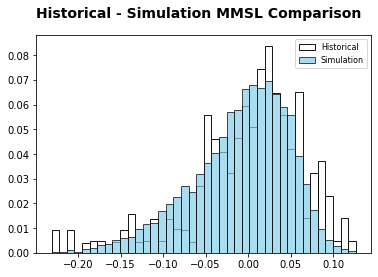

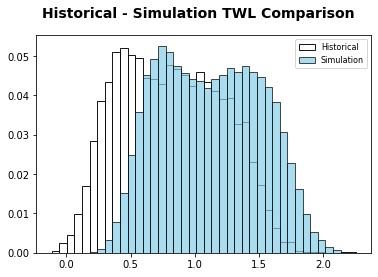

In [21]:
# plot histograms of historical and simulated levels

level_hist = data['level'].values[:]
level_sim = data_list[0].level.values[:]

level_hist = level_hist[~np.isnan(level_hist)]
level_sim = level_sim[~np.isnan(level_sim)]

at_hist = data['AT'].values[:]
at_sim = data_list[0].AT.values[:]

at_hist = at_hist[~np.isnan(at_hist)]
at_sim = at_sim[~np.isnan(at_sim)]

mmsl_hist = data['MMSL'].values[:]
mmsl_sim = data_list[0].MMSL.values[:]

mmsl_hist = mmsl_hist[~np.isnan(mmsl_hist)]
mmsl_sim = mmsl_sim[~np.isnan(mmsl_sim)]

twl_hist = data['TWL'].values[:]
twl_sim = data_list[0].TWL.values[:]

twl_hist = twl_hist[~np.isnan(twl_hist)]
twl_sim = twl_sim[~np.isnan(twl_sim)]

n_bins = 40

def axplot_histcompare(ax, var_fit, var_sim, n_bins):
    'axes plot histogram comparison between fit-sim waves variables'

    (_, bins, _) = ax.hist(var_fit, n_bins, weights=np.ones(len(var_fit)) / len(var_fit),
            alpha=0.9, color='white', ec='k', label = 'Historical')

    ax.hist(var_sim, bins=bins, weights=np.ones(len(var_sim)) / len(var_sim),
            alpha=0.7, color='skyblue', ec='k', label = 'Simulation')

    # customize axes
    ax.legend(prop={'size':8})
    #ax.set_facecolor('whitesmoke')
    #ax.set_xticks([])
    #ax.set_yticks([])

    
 
fig = plt.figure()
ax = plt.subplot()
axplot_histcompare(ax, level_hist, level_sim, n_bins)
fig.suptitle(
    'Historical - Simulation Level Comparison',
    fontsize=14, fontweight = 'bold'
)
plt.show()

fig = plt.figure()
ax = plt.subplot()
axplot_histcompare(ax, at_hist, at_sim, n_bins)
fig.suptitle(
    'Historical - Simulation AT Comparison',
    fontsize=14, fontweight = 'bold'
)
plt.show()

fig = plt.figure()
ax = plt.subplot()
axplot_histcompare(ax, mmsl_hist, mmsl_sim, n_bins)
fig.suptitle(
    'Historical - Simulation MMSL Comparison',
    fontsize=14, fontweight = 'bold'
)
plt.show()

fig = plt.figure()
ax = plt.subplot()
axplot_histcompare(ax, twl_hist, twl_sim, n_bins)
fig.suptitle(
    'Historical - Simulation TWL Comparison',
    fontsize=14, fontweight = 'bold'
)
plt.show()

In [98]:
print('Historical', len(waves.hs[~np.isnan(waves.level)]), len(hist_A.runup))
print('percentage outside limi9ts:',100-(len(hist_A.runup)*100/len(waves.hs[~np.isnan(waves.level)])) )
print('hs<1:', len(waves.hs[waves.hs<1]))
print('hs_lo2<0.005:', len(waves.hs_lo2[waves.hs_lo2<0.005]))

print('Simulated sim 0', len(waves_list[0].Hs), len(sim_A[0].runup))
print('percentage outside limits:',100 -(len(sim_A[0].runup)*100/len(waves_list[0].Hs)) )

print('limits')
print(var_lims)

Historical 1933 1872
percentage outside limi9ts: 3.1557165028453227
hs<1: 109
hs_lo2<0.005: 33
Simulated sim 0 113899 108118
percentage outside limits: 5.07554939024925
limits
{'level': array([-1.,  3.]), 'hs': array([1., 5.]), 'tp': array([ 3.4, 25.5]), 'rslope': array([0.05, 0.5 ]), 'bslope': array([0.05, 0.2 ]), 'rwidth': array([   0., 1500.]), 'cf': array([0.01, 0.1 ]), 'hs_lo2': [0.005, 0.05]}


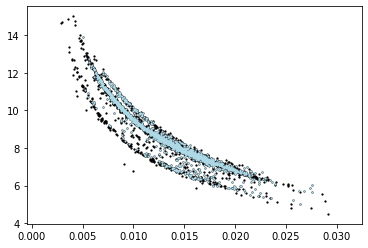

In [95]:

plt.figure()
#gs = gridspec.GridSpec(1, 1, wspace=0.2, hspace=0.2)
ax = plt.subplot()
ax.scatter(
    waves.hs_lo2, waves.tp,
    marker = '.',
    c = 'k',
    s = 6, label = 'historical'
)

# mda selection
ax.scatter(
    hist_A.hs_lo2, hist_A.tp,
    marker = '.',
    c = 'lightblue',
    s = 4, label='historical-runup'
)
plt.show()


## Methodology Validation: Annual Maxima

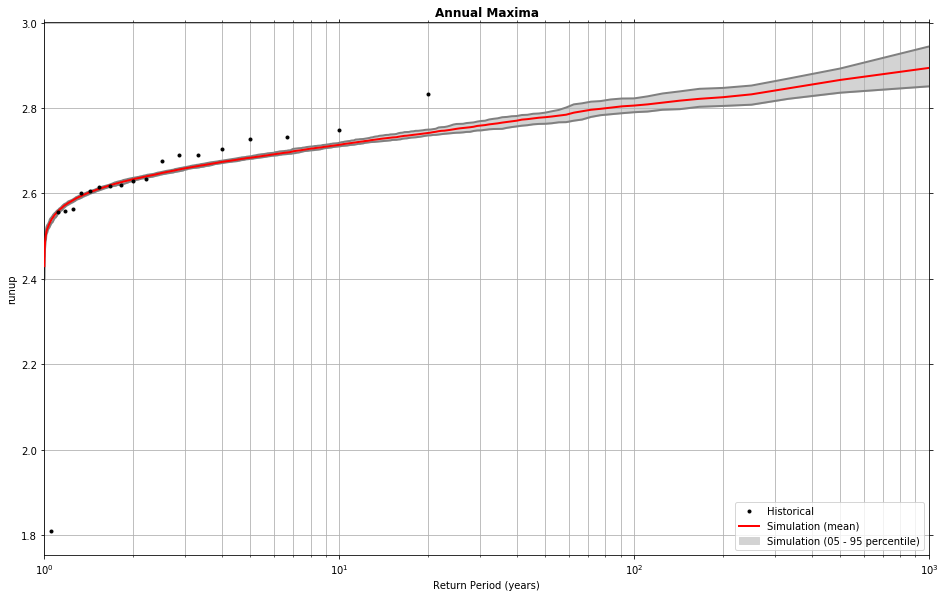

In [6]:

# compare historical and simulations runup annual maxima
hist_A = out_hist.to_xarray()['runup'].groupby('time.year').max(dim='time')
sim_A = xr.concat([x.to_xarray()['runup'].groupby('time.year').max(dim='time') for x in l_sims], 'n_sim')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A);


    